<a href="https://colab.research.google.com/github/ronaknavadiya/pytorch-projects-practice-/blob/Feature%2Foptimization/CNN_on_fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/zalando-research/fashionmnist")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ronaknavadiya
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist


100%|██████████| 68.8M/68.8M [00:00<00:00, 1.39GB/s]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
#  set random seeds for reproducebility
torch.manual_seed(42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:

df = pd.read_csv("/content/fashionmnist/fashion-mnist_train.csv")

# # Convert to small dataset due to CPU utilization
# df = df.sample(n=6000)
df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(60000, 785)

# Visualise data

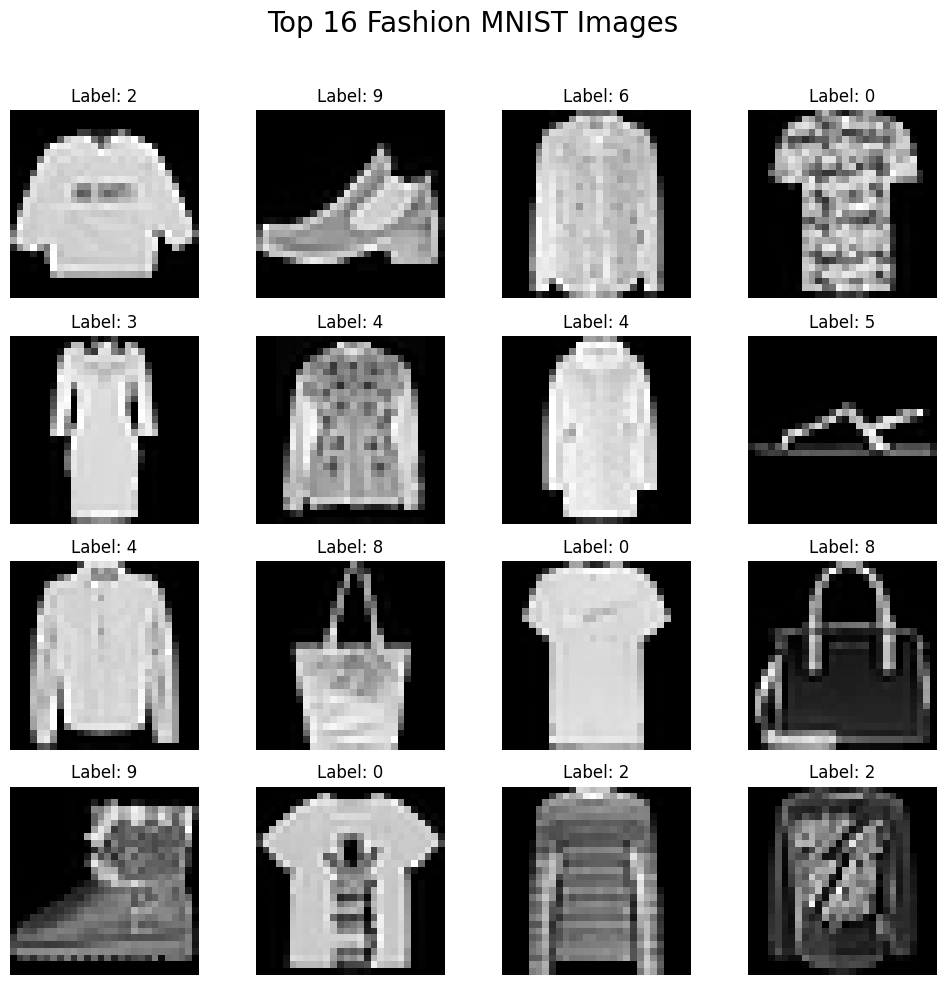

In [ ]:
#  create 4 x 4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("Top 16 Fashion MNIST Images", fontsize=20)

# plot the first 16 images from df
for i, ax in enumerate(axes.flat):
    ax.imshow(df.iloc[i, 1:].values.reshape(28, 28), cmap="gray")
    ax.axis("off")
    ax.set_title(f"Label: {df.iloc[i, 0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [ ]:
#  train test split

X = df.iloc[:,1:].values
y = df.iloc[:,0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#  Scale the features  (max_pixel = 255)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
#  create custom dataset

class CustomDataset(Dataset):

  def __init__(self,features, labels):
    self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    #  transformation


    return self.features[idx], self.labels[idx]


In [ ]:
#  create train_dataset and test_dataset object

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

print(len(train_dataset))
print(len(test_dataset))

48000
12000


In [ ]:
# train and test data loader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

# How my neural network will look like

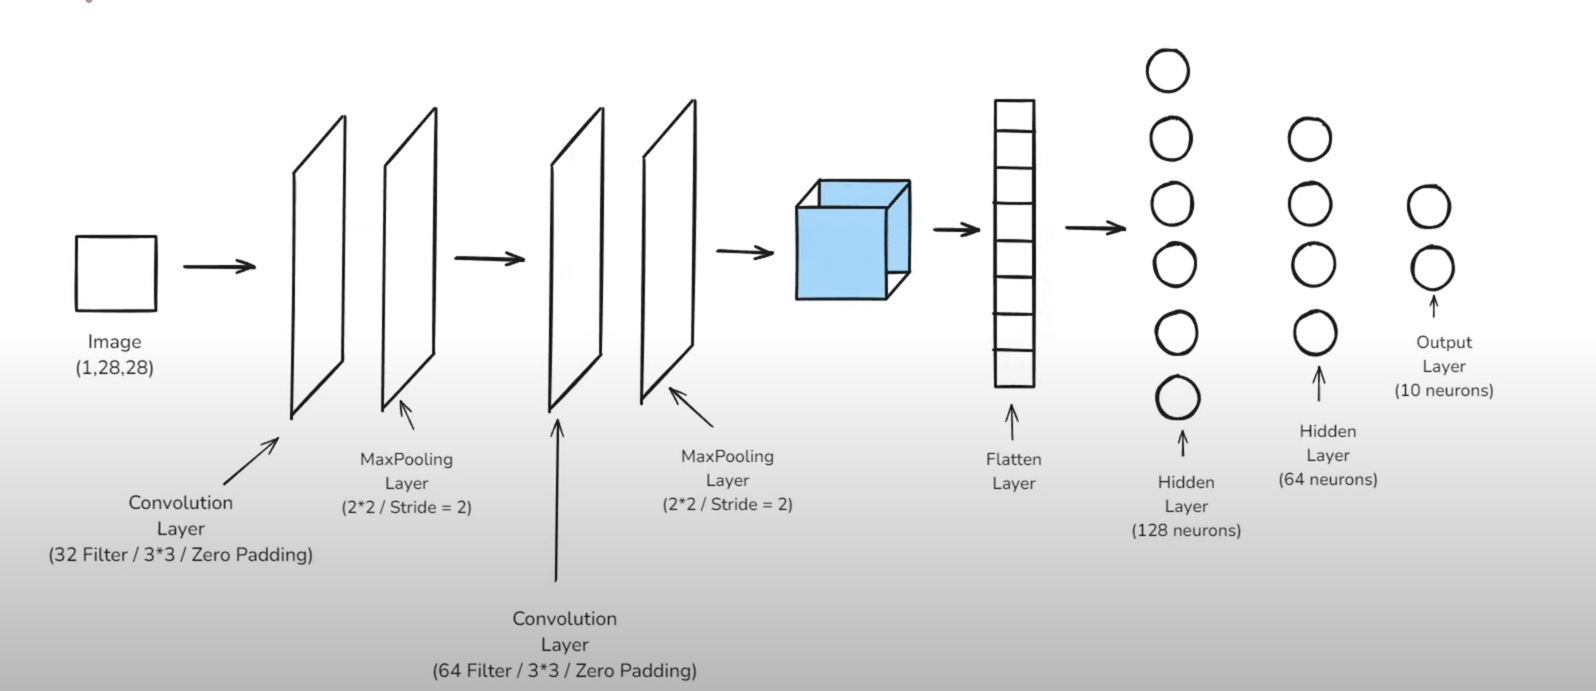


In [ ]:
# create NN

class My_NN(nn.Module):

  def __init__(self, input_features):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(input_features, 32, kernel_size = 3, padding = 'same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size = 2, stride=2),

        nn.Conv2d(32, 64, kernel_size = 3, padding = 'same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size = 2, stride=2)
    )


    self.clasifier = nn.Sequential(
        nn.Flatten(),

        nn.Linear(64*7*7, 128),
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(p= 0.4),

        nn.Linear(64, 10)

    )

  def forward(self, x):
    x = self.features(x)
    x = self.clasifier(x)
    return x


In [ ]:
# set learning rate and epochs
LR = 0.01
EPOCHS = 50

In [ ]:
# instantiate the model
model = My_NN(1)
model = model.to(device)

# loss function
criterian = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=LR, weight_decay= 1e-4)  # optimization

In [ ]:
# training loop

for epoch in range(EPOCHS):
  total_epoch_loss = 0
  for features,labels in train_dataloader:

    features = features.to(device)
    labels = labels.to(device)

    # forward pass
    X_train_pred = model(features)

    # calculate loss
    loss = criterian(X_train_pred, labels)

    # back propogation
    optimizer.zero_grad()
    loss.backward()

    # update weights
    optimizer.step()

    total_epoch_loss += loss.item()

  print(f"Epoch: {epoch} Average Loss: { total_epoch_loss/len(train_dataloader)}")




Epoch: 0 Average Loss: 0.6507016812066237
Epoch: 1 Average Loss: 0.3907744800622265
Epoch: 2 Average Loss: 0.33781896843512854
Epoch: 3 Average Loss: 0.30119493293017147
Epoch: 4 Average Loss: 0.2759836659505963
Epoch: 5 Average Loss: 0.25702730371057986
Epoch: 6 Average Loss: 0.24235603391254942
Epoch: 7 Average Loss: 0.22306830083703003
Epoch: 8 Average Loss: 0.21079767132674654
Epoch: 9 Average Loss: 0.20006539853165548
Epoch: 10 Average Loss: 0.18611062352980176
Epoch: 11 Average Loss: 0.18195221443163853
Epoch: 12 Average Loss: 0.170637877634416
Epoch: 13 Average Loss: 0.161429470964397
Epoch: 14 Average Loss: 0.1549450446742897
Epoch: 15 Average Loss: 0.14374285496771336
Epoch: 16 Average Loss: 0.14013715222679698
Epoch: 17 Average Loss: 0.13778590850764885
Epoch: 18 Average Loss: 0.12950372544924418
Epoch: 19 Average Loss: 0.11971823247366896
Epoch: 20 Average Loss: 0.11318855031036461
Epoch: 21 Average Loss: 0.1099868404820639
Epoch: 22 Average Loss: 0.10401466419904803
Epoch: 

In [ ]:
# set model to eval mode
model.eval()

My_NN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clasifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
# evalution code

total = 0
correct = 0

with torch.no_grad():
  for features,labels in test_dataloader:

    features = features.to(device)
    labels = labels.to(device)

    # forward pass
    X_test_pred = model(features)

    # get predictions
    predictions = torch.argmax(X_test_pred, dim=1)

    total = total + labels.size(0)
    correct = correct + (predictions == labels).sum().item()

    # loss
    loss = criterian(X_test_pred, labels)

  print(f"Test Accuracy: {correct/total * 100}% Loss: {loss}")





Test Accuracy: 92.46666666666667% Loss: 0.6372147798538208


In [ ]:
# Training evalution code

total = 0
correct = 0

with torch.no_grad():
  for features,labels in train_dataloader:

    features = features.to(device)
    labels = labels.to(device)

    # forward pass
    X_train_pred = model(features)

    # get predictions
    predictions = torch.argmax(X_train_pred, dim=1)

    total = total + labels.size(0)
    correct = correct + (predictions == labels).sum().item()

    # loss
    loss = criterian(X_train_pred, labels)

  print(f"Train Accuracy: {correct/total * 100}% Loss: {loss}")



Train Accuracy: 99.96041666666666% Loss: 1.710872857074719e-05
